Setup and utility functions

In [2]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from scipy.special import expit

# fix random seed
np.random.seed(0)

# Helper function to plot a decision boundary.
def plot_decision_boundary(X, pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

# Evaluation revisited: K-Fold Cross-Validation
The code below perfoms 4-fold cross-validation of a Logistic Regression classifier on the Iris dataset -- a dataset with 3 different classes of flowers, see https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html for a detailed description)

## Task 1
Run the code below with `k=3`. What went wrong and why? How can we fix it without changing `k`?

In [3]:
from sklearn.model_selection import KFold

iris = sklearn.datasets.load_iris()
k_fold = KFold(n_splits=3)
scores = []
for train_indices, test_indices in k_fold.split(iris.data):
    clf = sklearn.linear_model.LogisticRegression(solver='liblinear')
    clf.fit(iris.data[train_indices], iris.target[train_indices])  
    scores.append(clf.score(iris.data[test_indices],
                            iris.target[test_indices]))
    print('Accuracy: {}'.format(scores[-1]))
print ("Average accuracy {} +/- {}".format(np.mean(scores),np.std(scores)))

Accuracy: 0.0
Accuracy: 0.0
Accuracy: 0.0
Average accuracy 0.0 +/- 0.0


The data is ordered, i.e., we always train on two classes and test on the remaining 3rd class (that our model hasn't seen during training).  
To fix the problem, we use stratified splits that guarantee that the class distribution of the original data is maintained in each split.

In [4]:
from sklearn.model_selection import StratifiedKFold

k_fold = StratifiedKFold(n_splits=3) # stratified splits
scores = []
for train_indices, test_indices in k_fold.split(iris.data, iris.target):
    clf = sklearn.linear_model.LogisticRegression(solver='liblinear')
    clf.fit(iris.data[train_indices], iris.target[train_indices])  
    scores.append(clf.score(iris.data[test_indices],
                            iris.target[test_indices]))
    print('Accuracy: {}'.format(scores[-1]))
print ("Average accuracy {} +/- {}".format(np.mean(scores),np.std(scores)))

Accuracy: 0.96
Accuracy: 0.96
Accuracy: 0.94
Average accuracy 0.9533333333333333 +/- 0.009428090415820642


# Neural Networks

Logistic Regression can only provide a linear decision boundary, i.e., while it separates the data as good as it can using a straight line, it is unable to capture the true shape of the distribution of instances in the example below.

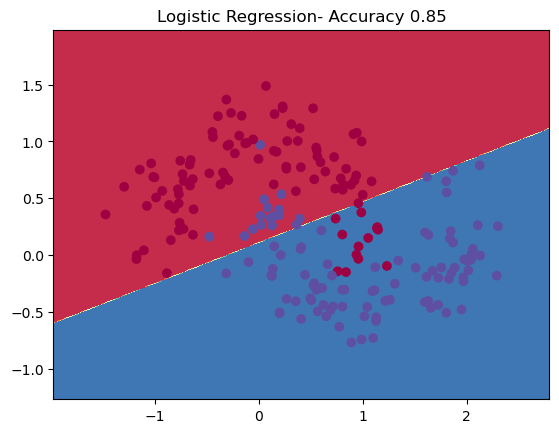

In [5]:
# Generate data with two "half moons"
x,y = sklearn.datasets.make_moons(200, noise=0.20,random_state=42)

# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegression()
clf.fit(x, y)

# Plot the decision boundary
plot_decision_boundary(x,clf.predict)
plt.title("Logistic Regression- Accuracy {}".format(sum(clf.predict(x) == y)/len(y)))
plt.show()

In this task, we implement a neural network, capable of non-linear separation of the classes. Implementation based on the tutorial [nn from scratch](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/), which uses tanh activation functions and a softmax in the output layer.

## Architecture

We build a 3-layer network with one input layer, one hidden layer and one output layer. 

The number of nodes in the input layer is determined by the dimensionality of our data, which is 2. Since our classification problem is binary, a single neuron in the output is sufficient. In the hidden layer, we are free to choose the number of neurons. The more nodes in the hidden layer, the more complex functions we will be able to fit. On the other hand, increasing the number of nodes in the hidden layer, means increasing the computation effort and we are more prone to overfitting. We will try different sizes of the hidden layer and see how it affects the output. 
We choose the sigmoid as activation function in the hidden and output layer.

<img src="./3FNN.png" width='300px'/>

## How our network makes predictions

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 2-dimensional input (row vector) to our network then we calculate our prediction $\hat{y}$ (one-dimensional) as follows:

$$
\begin{aligned}
z_1 & = W_1x^T + b_1 && \text{total input to hidden layer}\\
a_1 & = \mathrm{sigmoid}(z_1) && \text{hidden layer activation} \\
z_2 & = W_2a_1 + b_2 && \text{total input to output layer} \\
a_2 & = \hat{y} = \mathrm{sigmoid}(z_2) && \text{output layer activation}
\end{aligned}
$$

$z_i$ is the input of layer $i$ and $a_i$ is the output of layer $i$ after applying the activation function. $\theta = (W_1, b_1, W_2, b_2)$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{500\times2}$, $b_1 \in \mathbb{R}^{500\times1}$, $W_2 \in \mathbb{R}^{1\times500}$, $b_2 \in \mathbb{R}^{1\times1}$. Increasing the size of the hidden layer increases the amount of parameters in $W_1,W_2$ and $b_1$.

## Learning the Parameters

Learning the parameters for our network means finding parameters $(W_1,b_1,W_2,b_2)$ that minimize the error on our training data. We use the binary cross entropy as our loss function:
$$
\begin{aligned}
L(y,\hat{y}) = -\left[y \cdot \log(\hat{y} + (1-y) \cdot \log(1-\hat{y}) \right]
\end{aligned}
$$

Our goal is to find the parameters that minimize our loss function. We use gradient descent with a fixed learning rate to find its minimum. 

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\nabla\theta = (\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}})$. To calculate these gradients we use backpropagation.
Applying the backpropagation formula we find the following gradients for *full gradient descent*:

$$
\begin{aligned}
& \frac{\partial{L}}{\partial{W_2}} = \delta_2 A_1^T \\
& \frac{\partial{L}}{\partial{b_2}} = \sum \delta_2 \\
& \frac{\partial{L}}{\partial{W_1}} = \delta_1 x\\
& \frac{\partial{L}}{\partial{b_1}} = \sum \delta_1 \\
\end{aligned}
$$  

$$
\begin{aligned}
& \delta_2 = (\hat{y}-y)  \\
& \delta_1 = W_2^T\delta_2   a_1  (1- a_1) \\
\end{aligned}
$$

## Implementation
The code below implements full gradient descent, i.e., calculating the gradients for all examples in the training set and then doing an update step. 

### Task 2
Implement stochastic gradient descent (`stochastic=True` in the `fit` function), i.e., calculate the gradient for a single sample and immediately perform an update of the parameters. Make sure to iterate the data in randomized order in each epoch. Keep track of the loss values, by appending the current loss before each update to `loss_history`.

In [6]:
y = np.reshape(y, (y.shape[0],1)) # adjust the shape of the target values (make y a (#instances x score) "matrix")

In [10]:
import random

class FNN_model:
    def __init__(self, input_dim=2, hidden_dim=3):
        self.W1 = np.random.randn(hidden_dim, input_dim) / np.sqrt(input_dim) # normalize by "fan-in"
        self.b1 = np.zeros((hidden_dim,1))
        self.W2 = np.random.randn(1,hidden_dim) / np.sqrt(hidden_dim)
        self.b2 = np.zeros((1,1))
        self.loss_history = [] # keep track of loss
        
    def forward(self,x):
        z1 = self.W1.dot(x.T) + self.b1 # transpose x to get "column vectors"
        a1 = expit(z1)
        z2 = self.W2.dot(a1) + self.b2
        a2 = expit(z2)
        return a2.T,a1 # transpose a2 to get scores in shape (#instances x score)
    
    def predict(self,x):
        score = self.forward(x)[0]
        return np.where(score>0.5,1,0)
        
    def loss(self,x,y):
        score = self.forward(x)[0]
        return np.sum(-((y*np.log(score)) + (1-y)*np.log(1-score))) / x.shape[0] # average loss over provided samples
        
    def backprop(self,eta,x,y):
        # forward pass to get activations
        a2,a1 = self.forward(x)
        
        # gradients
        delta2 = (a2-y).T # forward gives shape (#instances x score), transpose to have #instances in trailing dimension
        dW2 = (delta2).dot(a1.T) # (1 x #instances) x (#instances x hidden_dim) => implicitly sum over all instances
        db2 = np.sum(delta2, axis=1, keepdims=True) # explicitly sum over all instances
        
        delta1 = (self.W2.T).dot(delta2) * a1 * (1-a1) # W2.T x delta2 => (hidden_dim x 1) x (1 x #instances), a1 (hidden_dim x #instances) => (hidden_dim x #instances)
        dW1 = np.dot(delta1,x) # (hidden_dim x #instances) x (#instances x input_dim) => implicitly sum over all instances
        db1 = np.sum(delta1, axis=1, keepdims=True) # explicitly sum over all instances
        
        # updates
        self.W1 -= eta * dW1
        self.b1 -= eta * db1
        self.W2 -= eta * dW2
        self.b2 -= eta * db2
    
    def fit(self,x,y,eta=0.01,epochs=2000, stochastic = False):
        for e in range(epochs):
            if stochastic:
                idx = list(range(x.shape[0]))
                random.shuffle(idx)
                for i in idx:
                    self.loss_history.append(self.loss(x[i].reshape(1,x[i].shape[0]),y[i].reshape(1,y[i].shape[0])))
                    self.backprop(eta,x[i].reshape(1,x[i].shape[0]),y[i].reshape(1,y[i].shape[0]))
            else:
                self.loss_history.append(self.loss(x,y))
                self.backprop(eta,x,y)

In [11]:
# alternative solution with more explicit calculations (decreased performance, more closely aligned to pen&paper)
import random

class FNN_model2:
    def __init__(self, input_dim=2, hidden_dim=3):
        self.W1 = np.random.randn(hidden_dim, input_dim) / np.sqrt(input_dim) # normalize by "fan-in"
        self.b1 = np.zeros((hidden_dim,1))
        self.W2 = np.random.randn(1,hidden_dim) / np.sqrt(hidden_dim)
        self.b2 = np.zeros((1,1))
        self.loss_history = [] # keep track of loss
        
    def forward(self,x): 
        z1 = self.W1.dot(x.T) + self.b1 # transpose x to get "column vector(s)"
        a1 = expit(z1)
        z2 = self.W2.dot(a1) + self.b2
        a2 = expit(z2)
        return a2,a1 
    
    def predict(self,x):
        score = (self.forward(x)[0]).T
        return np.where(score>0.5,1,0)
        
    def loss(self,x,y):
        score = self.forward(x)[0]
        return -((y*np.log(score)) + (1-y)*np.log(1-score)) 
        
    def backprop(self,x,y):
        assert x.shape[0] ==1 # we expect a single instance as input, i.e, a "row vector" of the instance
        # forward pass to get activations
        a2,a1 = self.forward(x)
        
        # gradients
        delta2 = (a2-y)
        dW2 = delta2*a1.T
        db2 = delta2
        
        delta1 = delta2 * self.W2.T * a1 * (1-a1) # transpose W2 to column vector, simultaneously calculate all partial derivatives along each weight/activation
        dW1 = np.dot(delta1,x) # simulatenously calculate all partial derivatives of all weights
        db1 = delta1
        
        return dW2,db2,dW1,db1
        
    
    def fit(self,x,y,eta=0.01,epochs=2000, stochastic = False):
        for e in range(epochs):
            if stochastic:
                idx = list(range(x.shape[0]))
                random.shuffle(idx)
                for i in idx:
                    x_tmp = np.expand_dims(x[i], axis = 0)
                    y_tmp = np.expand_dims(y[i], axis = 0)
                    self.loss_history.append(self.loss(x_tmp,y_tmp)[0][0])
                    
                    dW2,db2,dW1,db1 = self.backprop(x_tmp,y_tmp)
                    # updates
                    self.W1 -= eta * dW1
                    self.b1 -= eta * db1
                    self.W2 -= eta * dW2
                    self.b2 -= eta * db2
            else:
                loss = np.zeros((1,1))
                dW2 = np.zeros_like(self.W2)
                db2 = np.zeros_like(self.b2)
                dW1 = np.zeros_like(self.W1)
                db1 = np.zeros_like(self.b1)
                for i in range(x.shape[0]):
                    x_tmp = np.expand_dims(x[i], axis = 0)
                    y_tmp = np.expand_dims(y[i], axis = 0)
                    loss += self.loss(x_tmp,y_tmp)
                    gradients = self.backprop(x_tmp,y_tmp)
                    dW2 += gradients[0]
                    db2 += gradients[1]
                    dW1 += gradients[2]
                    db1 += gradients[3]
                self.loss_history.append(loss[0][0] / x.shape[0])
                # updates
                self.W1 -= eta * dW1
                self.b1 -= eta * db1
                self.W2 -= eta * dW2
                self.b2 -= eta * db2

## Evaluation
Below, we plot the decision boundary for varying dimensions of the hidden layer. Already with 3 neurons in the hidden layer, the network is reasonable capable to separate the classes. With an increasing number of neurons in the hidden layer, it starts to overfit.

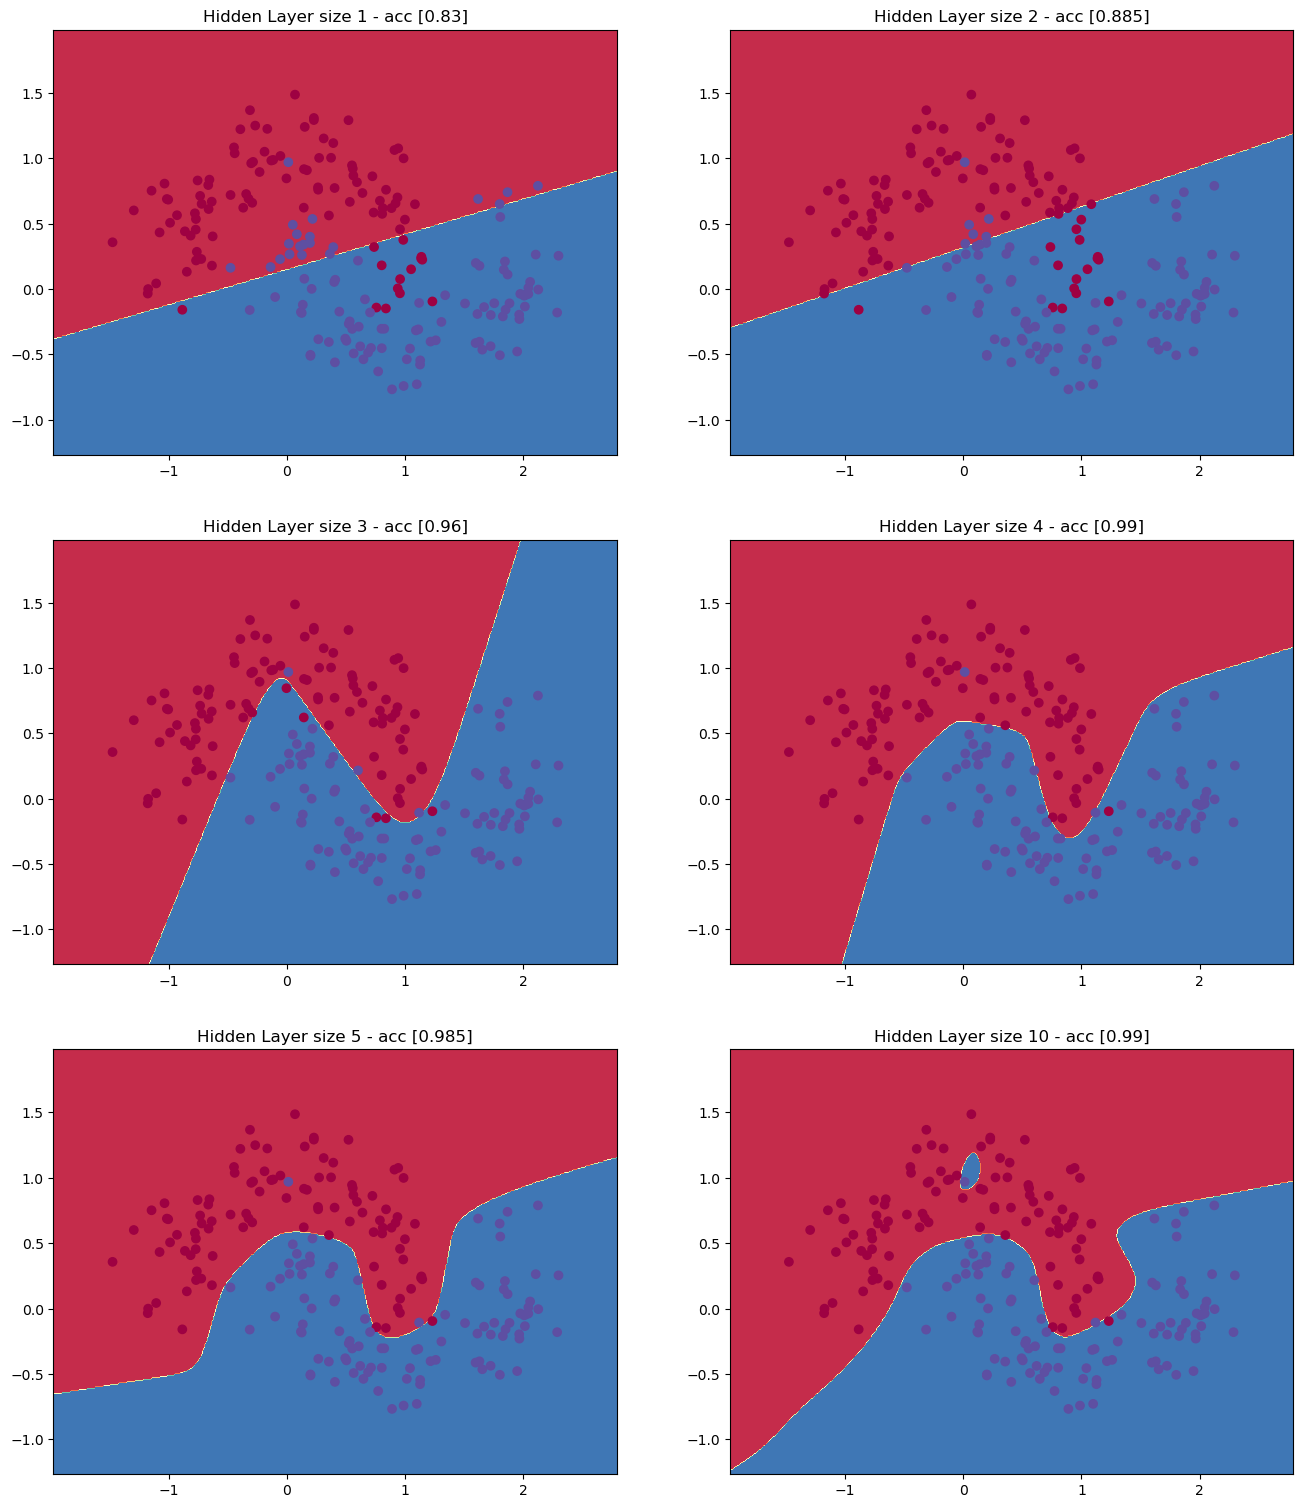

In [12]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 10]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    nn = FNN_model(hidden_dim=nn_hdim)
    nn.fit(x,y,epochs=20000, eta=0.03)
    plot_decision_boundary(x,nn.predict)
    plt.title('Hidden Layer size {} - acc {}'.format(nn_hdim,sum(nn.predict(x)==y)/x.shape[0]))
plt.show()

## Task 3: Stochastic vs. Full Gradient Descent
Train two models `sgd` and `fgd` with 3 neurons in the hidden layer, the former with stochastic gradient descent, the latter with full gradient descent. Plot the loss values for the first 10 epoches. Plot all loss values for `sgd`. As `fgd` calculates the loss only once per epoch, plot them only at these points.

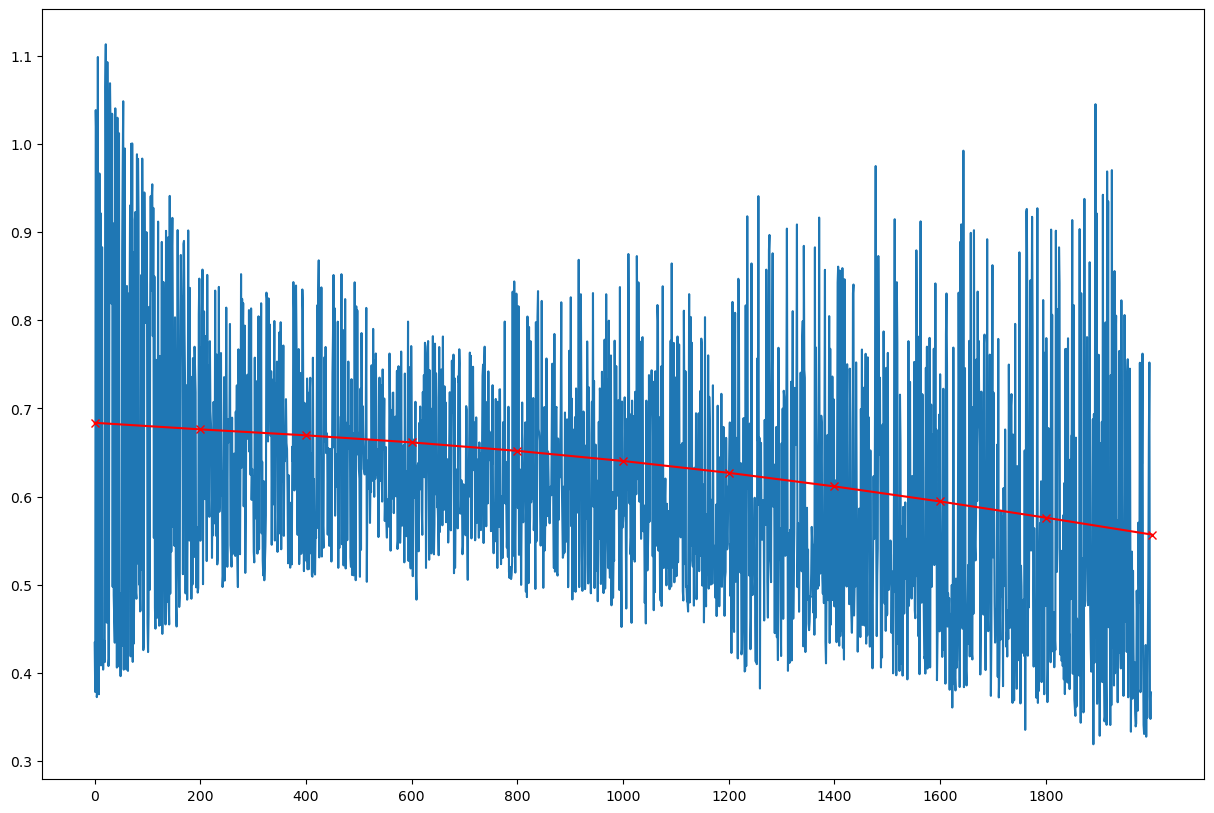

In [25]:
sgd = FNN_model()
sgd.fit(x,y,stochastic=True, epochs=20)
fgd = FNN_model()
fgd.fit(x,y,epochs=20)

plt.figure(figsize=(15,10))
steps = 10*x.shape[0]
plt.plot(range(len(sgd.loss_history[:steps])),sgd.loss_history[:steps])
plt.plot([i*x.shape[0] for i in range(int(steps/x.shape[0])+1)],fgd.loss_history[:int(steps/x.shape[0])+1], 'r-x')
plt.xticks([i for i in range(steps) if i % x.shape[0] == 0]);